## P39 to 41

- Ok ok ok ok ok
- Time to nail down 2-4 interestin directions in parameter space
- I want to put 2 together to make a cool/interesting global view
- Then I'll need to fake gradient descent on that, that should be interesting. 

In [ ]:
# ! pip install transformers matplotlib tqdm huggingface_hub

In [1]:
# from huggingface_hub import login
# login()

In [1]:
import torch
from transformers import pipeline
from torch.nn import functional as F
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib import cm
import os
import copy
from collections import OrderedDict

from transformers import GPT2LMHeadModel, GPT2Tokenizer, GPT2Config
from transformers import LlamaForCausalLM, PreTrainedTokenizerFast, LlamaConfig
from transformers import AutoModelForCausalLM, AutoTokenizer

device='cuda'

In [2]:
model_id = "meta-llama/Llama-3.2-1B"
# model_id = "openai-community/gpt2"
# model_id = "google/gemma-3-1b-pt"
# model_id = "gpt2"

In [3]:
# #Only needed for llama random initialization
# config_dict = {
#   "_attn_implementation_autoset": True,
#   "architectures": [
#     "LlamaForCausalLM"
#   ],
#   "attention_bias": False,
#   "attention_dropout": 0.0,
#   "bos_token_id": 128000,
#   "eos_token_id": 128001,
#   "head_dim": 64,
#   "hidden_act": "silu",
#   "hidden_size": 2048,
#   "initializer_range": 0.02,
#   "intermediate_size": 8192,
#   "max_position_embeddings": 131072,
#   "mlp_bias": False,
#   "model_type": "llama",
#   "num_attention_heads": 32,
#   "num_hidden_layers": 16,
#   "num_key_value_heads": 8,
#   "pretraining_tp": 1,
#   "rms_norm_eps": 1e-05,
#   "rope_scaling": {
#     "factor": 32.0,
#     "high_freq_factor": 4.0,
#     "low_freq_factor": 1.0,
#     "original_max_position_embeddings": 8192,
#     "rope_type": "llama3"
#   },
#   "rope_theta": 500000.0,
#   "tie_word_embeddings": True,
#   "torch_dtype": "float32",
#   "transformers_version": "4.50.3",
#   "use_cache": True,
#   "vocab_size": 128256
# }

In [4]:
# Random init
# model_config = GPT2Config() #Full sized model
# model = GPT2LMHeadModel(model_config).to(device) #Ok i should see what happens with full and pretrained model. 
# tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

# # Llama with random initialization
# model_config  = LlamaConfig.from_dict(config_dict)
# model = LlamaForCausalLM(model_config).to(device) 
# tokenizer = AutoTokenizer.from_pretrained(model_id)

#Pretrained
model = AutoModelForCausalLM.from_pretrained(model_id).to(device)
tokenizer = AutoTokenizer.from_pretrained(model_id)

In [5]:
text = "The capital of France is Paris"
inputs = tokenizer(text, return_tensors="pt").to(device)
input_ids = inputs["input_ids"]

In [6]:
with torch.no_grad():
    outputs = model(input_ids, labels=input_ids)

my_probs=F.softmax(outputs.logits, dim=-1)
y_one_hot=F.one_hot(input_ids, num_classes=model.config.vocab_size)
correct_next_token_probs = (my_probs[:,:-1]*y_one_hot[:,1:]).sum(-1) #I'm sure there's waaay more efficient ways to do this
my_loss=-torch.log(correct_next_token_probs).mean()
print(my_loss.item(), outputs.loss.item())

3.3751838207244873 3.3751838207244873


- To Do -> try with just loss on Paris token

In [7]:
with torch.no_grad():
    outputs = model(input_ids, labels=input_ids)

my_probs=F.softmax(outputs.logits, dim=-1)
y_one_hot=F.one_hot(input_ids, num_classes=model.config.vocab_size)
correct_next_token_probs = (my_probs[:,:-1]*y_one_hot[:,1:]).sum(-1) #I'm sure there's waaay more efficient ways to do this
my_loss=-torch.log(correct_next_token_probs).mean()

paris_only_loss=-np.log(my_probs[0, 5, 12366].item())
print(my_loss.item(), outputs.loss.item(), paris_only_loss)

3.3751838207244873 3.3751838207244873 0.9376916737061879


In [8]:
def get_random_directions(params, seed=None):
    """
    Generate random direction vectors for each parameter tensor.
    
    Args:
        params: List of (name, parameter) tuples from model.named_parameters()
        seed: Random seed for reproducibility
        
    Returns:
        direction: OrderedDict mapping parameter names to random direction tensors
    """
    if seed is not None:
        torch.manual_seed(seed)
        np.random.seed(seed)
    
    direction = OrderedDict()
    for name, param in params:
        if param.requires_grad:
            direction[name] = torch.randn_like(param.data)
    
    return direction

In [9]:
def normalize_direction(direction, params):
    """
    Normalize the direction tensors to match the norm of each parameter tensor.
    
    Args:
        direction: OrderedDict mapping parameter names to direction tensors
        params: List of (name, parameter) tuples from model.named_parameters()
        
    Returns:
        normalized_direction: OrderedDict with normalized direction tensors
    """
    param_dict = OrderedDict(params)
    normalized_direction = OrderedDict()
    
    for name, dir_tensor in direction.items():
        param_norm = torch.norm(param_dict[name].data)
        dir_norm = torch.norm(dir_tensor)
        
        # Avoid division by zero
        if dir_norm > 0:
            normalized_direction[name] = dir_tensor * (param_norm / dir_norm)
        else:
            normalized_direction[name] = dir_tensor
    
    return normalized_direction

In [45]:
# def attention_filter(name):
#     return "attn" in name

# def mlp_filter(name):
#     return "mlp" in name

# param_filter=mlp_filter
# # Filter parameters if a filter function is provided
# if param_filter is None:
#     # Default: use all parameters that require gradients
#     filtered_params = [(name, p) for name, p in model.named_parameters() if p.requires_grad]
# else:
#     filtered_params = [(name, p) for name, p in model.named_parameters() 
#                       if p.requires_grad and param_filter(name)]

In [155]:
filtered_params = [(name, p) for name, p in model.named_parameters() if p.requires_grad]
# filtered_params = filtered_params[:64] #Should be close to what i was doing before, don't do all tensors yet
# filtered_params = filtered_params[1:] #Everythign except embeddings - some nice structure here for sure, alittle more parabolic than I woudl like
# filtered_params = filtered_params[1:9] #First Layer
# filtered_params = filtered_params[1:37] #First 4 layers - pretty nice
# filtered_params = filtered_params[1:46] #First 5 layers - some nice structure here
# filtered_params = filtered_params[1:73] #First 8 layers - I like this - facorite so far
# filtered_params = filtered_params[:73] #First 8 layers including embedding - i slightly prefer the no embeddings vesrion for the 1 direction I looked at. 
# filtered_params = filtered_params[1:109] #First 12 layers - I like this too. 
# filtered_params = filtered_params[136:] #Last layer - meh prettty smooth
# filtered_params = filtered_params[99:] #Last 4 layers - ok, not amazing.
# filtered_params = filtered_params[73:] #Last 8 layers - some nice structue, but yeah more parabolic than I would like. 

In [156]:
len(filtered_params)

73

In [157]:
# for i in range(len(filtered_params)):
#     print(i, filtered_params[i][0])

In [158]:
# filtered_params

In [159]:
# Generate and normalize random directions
direction1 = get_random_directions(filtered_params, seed=2)
direction1 = normalize_direction(direction1, filtered_params)

In [160]:
len(direction1)

73

In [161]:
original_params = OrderedDict()
for name, param in filtered_params:
    original_params[name] = param.data.clone()

In [162]:
num_points=512 #32
alphas=np.linspace(-2.5, 2.5, num_points)

100%|███████████████████████████████████████████████████████| 512/512 [00:14<00:00, 36.25it/s]


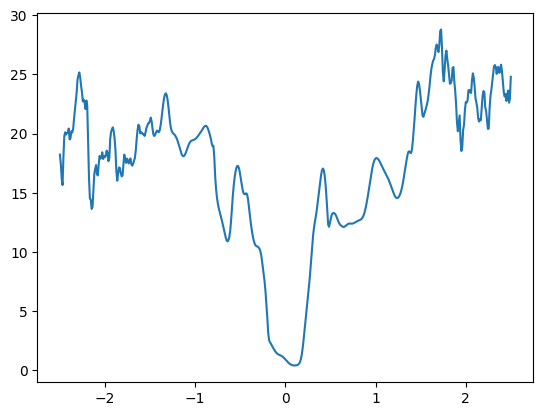

In [163]:
losses=[]
with torch.no_grad():
    for i, alpha in enumerate(tqdm(alphas)):
        for name, param in model.named_parameters():
            if name in direction1:
                param.data = original_params[name] + alpha * direction1[name]
        
        outputs = model(input_ids, labels=input_ids)
        my_probs=F.softmax(outputs.logits, dim=-1)
        paris_only_loss=-np.log(my_probs[0, 5, 12366].item())
        losses.append(paris_only_loss)
    
    for name, param in model.named_parameters(): # Restore original parameters
        if name in original_params: 
            param.data.copy_(original_params[name])

plt.plot(alphas, losses)

100%|███████████████████████████████████████████████████████| 512/512 [00:12<00:00, 42.50it/s]


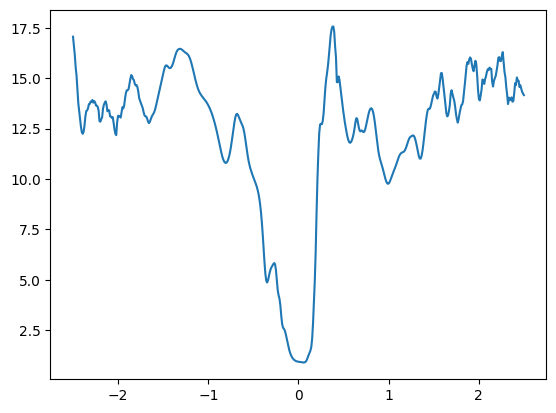

In [154]:
losses=[]
with torch.no_grad():
    for i, alpha in enumerate(tqdm(alphas)):
        for name, param in model.named_parameters():
            if name in direction1:
                param.data = original_params[name] + alpha * direction1[name]
        
        outputs = model(input_ids, labels=input_ids)
        my_probs=F.softmax(outputs.logits, dim=-1)
        paris_only_loss=-np.log(my_probs[0, 5, 12366].item())
        losses.append(paris_only_loss)
    
    for name, param in model.named_parameters(): # Restore original parameters
        if name in original_params: 
            param.data.copy_(original_params[name])

plt.plot(alphas, losses)

100%|█████████████████████████████████████████████████████| 1024/1024 [00:34<00:00, 30.03it/s]


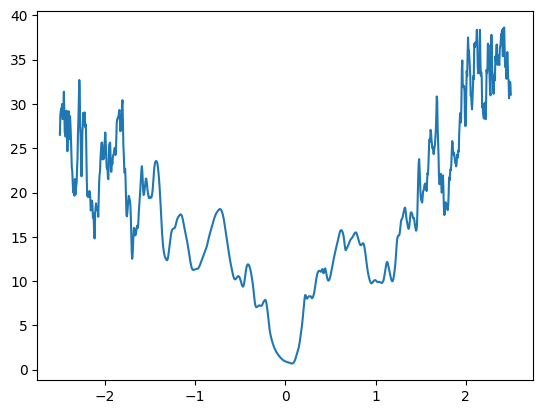

In [127]:
num_points=1024 #32
alphas=np.linspace(-2.5, 2.5, num_points)

losses=[]
with torch.no_grad():
    for i, alpha in enumerate(tqdm(alphas)):
        for name, param in model.named_parameters():
            if name in direction1:
                param.data = original_params[name] + alpha * direction1[name]
        
        outputs = model(input_ids, labels=input_ids)
        my_probs=F.softmax(outputs.logits, dim=-1)
        paris_only_loss=-np.log(my_probs[0, 5, 12366].item())
        losses.append(paris_only_loss)
    
    for name, param in model.named_parameters(): # Restore original parameters
        if name in original_params: 
            param.data.copy_(original_params[name])

plt.plot(alphas, losses)

100%|███████████████████████████████████████████████████████| 128/128 [00:02<00:00, 45.08it/s]


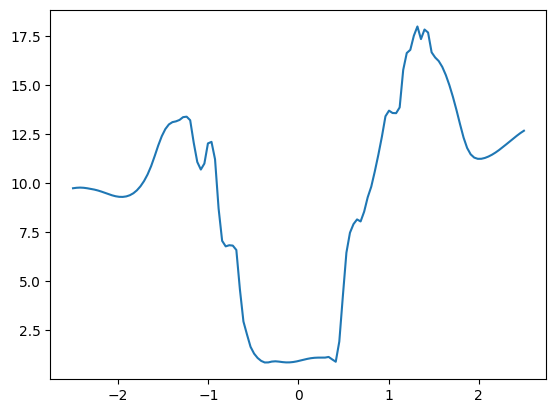

In [36]:
# Generate and normalize random directions
direction1 = get_random_directions(filtered_params, seed=2)
direction1 = normalize_direction(direction1, filtered_params)

original_params = OrderedDict()
for name, param in filtered_params:
    original_params[name] = param.data.clone()

num_points=128
alphas=np.linspace(-2.5, 2.5, num_points)

losses=[]
with torch.no_grad():
    for i, alpha in enumerate(tqdm(alphas)):
        for name, param in model.named_parameters():
            if name in direction1:
                param.data = original_params[name] + alpha * direction1[name]
        
        outputs = model(input_ids, labels=input_ids)
        my_probs=F.softmax(outputs.logits, dim=-1)
        paris_only_loss=-np.log(my_probs[0, 5, 12366].item())
        losses.append(paris_only_loss)
    
    for name, param in model.named_parameters(): # Restore original parameters
        if name in original_params: 
            param.data.copy_(original_params[name])

plt.plot(alphas, losses)

100%|███████████████████████████████████████████████| 512/512 [00:13<00:00, 37.64it/s]


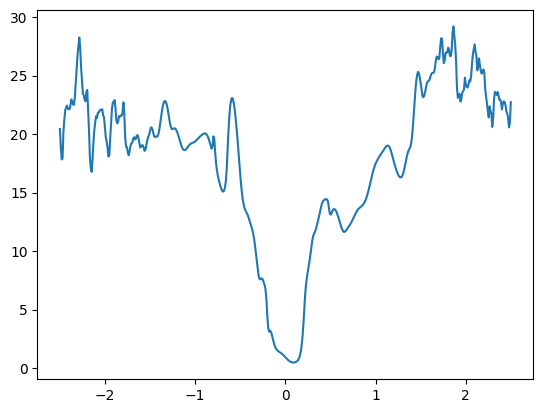

In [23]:
# Generate and normalize random directions
direction1 = get_random_directions(filtered_params, seed=2)
direction1 = normalize_direction(direction1, filtered_params)

original_params = OrderedDict()
for name, param in filtered_params:
    original_params[name] = param.data.clone()

num_points=512
alphas=np.linspace(-2.5, 2.5, num_points)

losses=[]
with torch.no_grad():
    for i, alpha in enumerate(tqdm(alphas)):
        for name, param in model.named_parameters():
            if name in direction1:
                param.data = original_params[name] + alpha * direction1[name]
        
        outputs = model(input_ids, labels=input_ids)
        my_probs=F.softmax(outputs.logits, dim=-1)
        paris_only_loss=-np.log(my_probs[0, 5, 12366].item())
        losses.append(paris_only_loss)
    
    for name, param in model.named_parameters(): # Restore original parameters
        if name in original_params: 
            param.data.copy_(original_params[name])

plt.plot(alphas, losses)

100%|██████████████████████████████████| 512/512 [00:13<00:00, 37.73it/s]


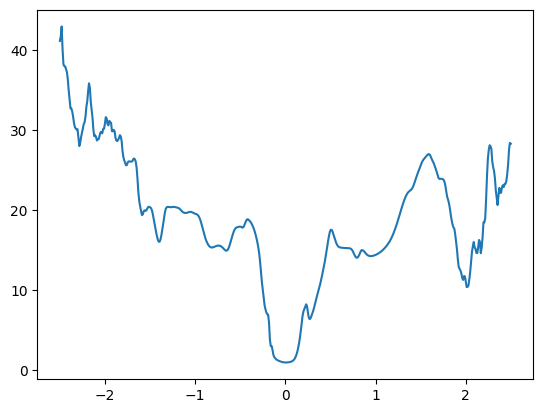

In [19]:
# Generate and normalize random directions
direction1 = get_random_directions(filtered_params, seed=3)
direction1 = normalize_direction(direction1, filtered_params)

original_params = OrderedDict()
for name, param in filtered_params:
    original_params[name] = param.data.clone()

num_points=128
alphas=np.linspace(-2.5, 2.5, num_points)

losses=[]
with torch.no_grad():
    for i, alpha in enumerate(tqdm(alphas)):
        for name, param in model.named_parameters():
            if name in direction1:
                param.data = original_params[name] + alpha * direction1[name]
        
        outputs = model(input_ids, labels=input_ids)
        my_probs=F.softmax(outputs.logits, dim=-1)
        paris_only_loss=-np.log(my_probs[0, 5, 12366].item())
        losses.append(paris_only_loss)
    
    for name, param in model.named_parameters(): # Restore original parameters
        if name in original_params: 
            param.data.copy_(original_params[name])

plt.plot(alphas, losses)

100%|██████████████████████████████████| 128/128 [00:03<00:00, 37.40it/s]


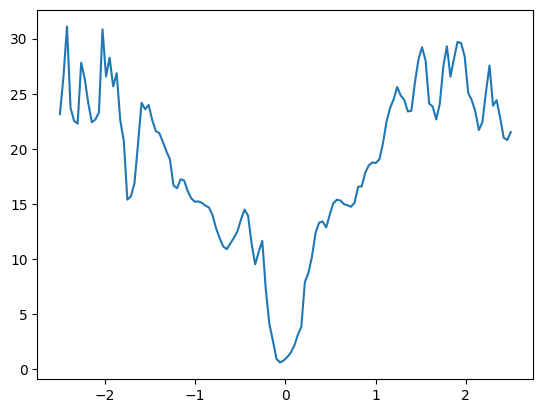

In [20]:
# Generate and normalize random directions
direction1 = get_random_directions(filtered_params, seed=4)
direction1 = normalize_direction(direction1, filtered_params)

original_params = OrderedDict()
for name, param in filtered_params:
    original_params[name] = param.data.clone()

num_points=128
alphas=np.linspace(-2.5, 2.5, num_points)

losses=[]
with torch.no_grad():
    for i, alpha in enumerate(tqdm(alphas)):
        for name, param in model.named_parameters():
            if name in direction1:
                param.data = original_params[name] + alpha * direction1[name]
        
        outputs = model(input_ids, labels=input_ids)
        my_probs=F.softmax(outputs.logits, dim=-1)
        paris_only_loss=-np.log(my_probs[0, 5, 12366].item())
        losses.append(paris_only_loss)
    
    for name, param in model.named_parameters(): # Restore original parameters
        if name in original_params: 
            param.data.copy_(original_params[name])

plt.plot(alphas, losses)

100%|██████████████████████████████████| 128/128 [00:03<00:00, 37.48it/s]


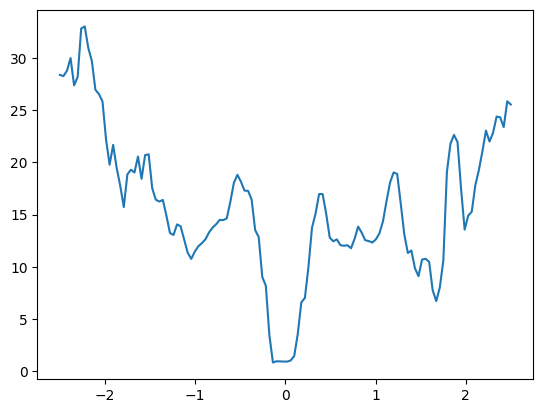

In [21]:
# Generate and normalize random directions
direction1 = get_random_directions(filtered_params, seed=5)
direction1 = normalize_direction(direction1, filtered_params)

original_params = OrderedDict()
for name, param in filtered_params:
    original_params[name] = param.data.clone()

num_points=128
alphas=np.linspace(-2.5, 2.5, num_points)

losses=[]
with torch.no_grad():
    for i, alpha in enumerate(tqdm(alphas)):
        for name, param in model.named_parameters():
            if name in direction1:
                param.data = original_params[name] + alpha * direction1[name]
        
        outputs = model(input_ids, labels=input_ids)
        my_probs=F.softmax(outputs.logits, dim=-1)
        paris_only_loss=-np.log(my_probs[0, 5, 12366].item())
        losses.append(paris_only_loss)
    
    for name, param in model.named_parameters(): # Restore original parameters
        if name in original_params: 
            param.data.copy_(original_params[name])

plt.plot(alphas, losses)

100%|██████████████████████████████████| 128/128 [00:03<00:00, 37.44it/s]


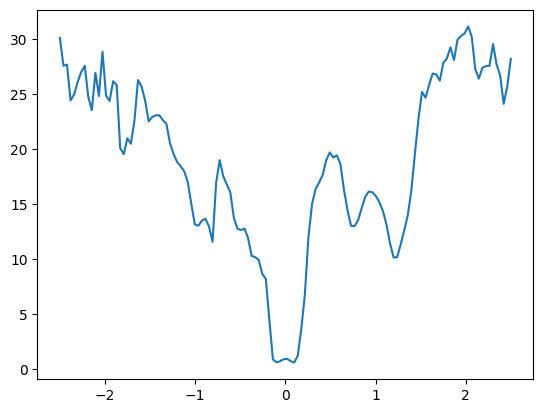

In [22]:
# Generate and normalize random directions
direction1 = get_random_directions(filtered_params, seed=6)
direction1 = normalize_direction(direction1, filtered_params)

original_params = OrderedDict()
for name, param in filtered_params:
    original_params[name] = param.data.clone()

num_points=128
alphas=np.linspace(-2.5, 2.5, num_points)

losses=[]
with torch.no_grad():
    for i, alpha in enumerate(tqdm(alphas)):
        for name, param in model.named_parameters():
            if name in direction1:
                param.data = original_params[name] + alpha * direction1[name]
        
        outputs = model(input_ids, labels=input_ids)
        my_probs=F.softmax(outputs.logits, dim=-1)
        paris_only_loss=-np.log(my_probs[0, 5, 12366].item())
        losses.append(paris_only_loss)
    
    for name, param in model.named_parameters(): # Restore original parameters
        if name in original_params: 
            param.data.copy_(original_params[name])

plt.plot(alphas, losses)

100%|███████████████████████████████████████████████████████| 512/512 [00:20<00:00, 25.41it/s]


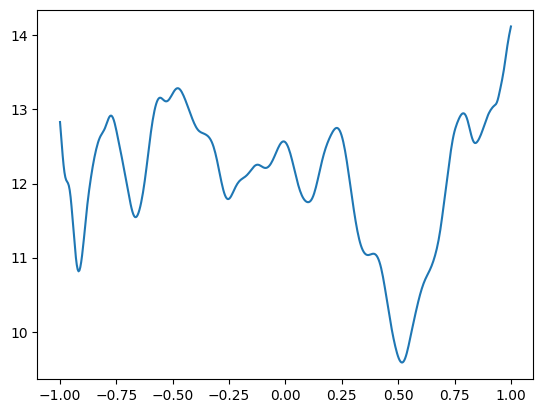

In [22]:
filtered_params = [(name, p) for name, p in model.named_parameters() if p.requires_grad]
# filtered_params = filtered_params[64:] #Should be close to what i was doing before, don't do all tensors yet

# Generate and normalize random directions
direction1 = get_random_directions(filtered_params, seed=3)
direction1 = normalize_direction(direction1, filtered_params)

original_params = OrderedDict()
for name, param in filtered_params:
    original_params[name] = param.data.clone()

num_points=512
# alphas=np.linspace(-2.5, 2.5, num_points)
alphas=np.linspace(-1.0, 1.0, num_points) #"zoom in for all params"???

losses=[]
with torch.no_grad():
    for i, alpha in enumerate(tqdm(alphas)):
        for name, param in model.named_parameters():
            if name in direction1:
                param.data = original_params[name] + alpha * direction1[name]
        
        outputs = model(input_ids, labels=input_ids)
        my_probs=F.softmax(outputs.logits, dim=-1)
        paris_only_loss=-np.log(my_probs[0, 5, 12366].item())
        losses.append(paris_only_loss)
    
    for name, param in model.named_parameters(): # Restore original parameters
        if name in original_params: 
            param.data.copy_(original_params[name])

plt.plot(alphas, losses)

In [28]:
len(filtered_params)

146

- Ok yeah i want to noodle a little more here before I commit
- Potentially interesting variables

1. Dataset (will have to do this later anyway)
2. How I'm filtering on layers (all layers kinda sucks - too parabolic!
3. Random weights - I think i tried this...but definitely want to look again...
4. Sortof trained or something? Not sure...

If random inits are interesting, this could be cool/meaningful to explain in the script quickly. I think that's potentially a nice explanation dpending on how the plots look. All params might be ok too if I zoom in? We'll se...

100%|███████████████████████████████████████████████████████| 128/128 [00:03<00:00, 41.96it/s]


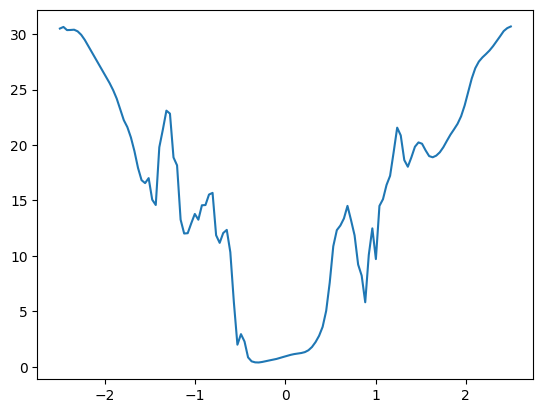

In [74]:
filtered_params = [(name, p) for name, p in model.named_parameters() if p.requires_grad]
# filtered_params = filtered_params[64:] #Should be close to what i was doing before, don't do all tensors yet
# np.random.seed(2)
random_tensor_indices=np.random.choice(np.arange(len(filtered_params)), 32)
filtered_params = [filtered_params[i] for i in random_tensor_indices]

# Generate and normalize random directions
direction1 = get_random_directions(filtered_params, seed=6)
direction1 = normalize_direction(direction1, filtered_params)

original_params = OrderedDict()
for name, param in filtered_params:
    original_params[name] = param.data.clone()

num_points=128
alphas=np.linspace(-2.5, 2.5, num_points)

losses=[]
with torch.no_grad():
    for i, alpha in enumerate(tqdm(alphas)):
        for name, param in model.named_parameters():
            if name in direction1:
                param.data = original_params[name] + alpha * direction1[name]
        
        outputs = model(input_ids, labels=input_ids)
        my_probs=F.softmax(outputs.logits, dim=-1)
        paris_only_loss=-np.log(my_probs[0, 5, 12366].item())
        losses.append(paris_only_loss)
    
    for name, param in model.named_parameters(): # Restore original parameters
        if name in original_params: 
            param.data.copy_(original_params[name])

plt.plot(alphas, losses)

array([15])

In [13]:
def compute_loss_landscape(model, inputs, alpha_range, beta_range, direction1, direction2, 
                          n_points=20, compute_loss_fn=None, original_params=None):
    """
    Compute the loss landscape by moving along two random directions.
    
    Args:
        model: Neural network model
        inputs: Input data dictionary
        alpha_range: Range for the first direction (min, max)
        beta_range: Range for the second direction (min, max)
        direction1: First normalized direction
        direction2: Second normalized direction
        n_points: Number of points in each direction
        compute_loss_fn: Function to compute loss (if None, uses default)
        
    Returns:
        alphas: Values for first direction
        betas: Values for second direction
        loss_surface: 2D array of loss values
    """
    # Default loss computation function
    if compute_loss_fn is None:
        def compute_loss_fn(model, inputs):
            outputs = model(**inputs, labels=inputs['input_ids'])
            return outputs.loss.item()
            
    # Save original parameters
    if original_params is None: 
        original_params = OrderedDict()
        for name, param in model.named_parameters():
            if name in direction1:
                original_params[name] = param.data.clone()
    
    # Create grid of alpha and beta values
    alphas = np.linspace(alpha_range[0], alpha_range[1], n_points)
    betas = np.linspace(beta_range[0], beta_range[1], n_points)
    loss_surface = np.zeros((n_points, n_points))
    
    # Compute loss at each point on the grid
    for i, alpha in enumerate(tqdm(alphas)):
        for j, beta in enumerate(betas):
            # Update model parameters: W' = W + alpha*d1 + beta*d2
            for name, param in model.named_parameters():
                if name in direction1 and name in direction2:
                    param.data = original_params[name] + alpha * direction1[name] + beta * direction2[name]
            
            # Compute loss
            loss_surface[i, j] = compute_loss_fn(model, inputs)
    
    # Restore original parameters
    for name, param in model.named_parameters():
        if name in original_params:
            param.data.copy_(original_params[name])
    
    return alphas, betas, loss_surface

In [ ]:
def visualize_landscape(alphas, betas, loss_surface, trajectory=None, title="Loss Landscape", 
                        save_path=None, fig_size=(10, 8)):
    """
    Create a contour plot visualization of the loss landscape.
    
    Args:
        alphas: Values for first direction
        betas: Values for second direction
        loss_surface: 2D array of loss values
        trajectory: List of (alpha, beta) points to plot the optimization trajectory
        title: Plot title
        save_path: Path to save the figure
        fig_size: Figure size (width, height)
        
    Returns:
        fig, ax: The figure and axis objects
    """
    fig, ax = plt.subplots(figsize=fig_size)
    
    # Create a contour plot
    X, Y = np.meshgrid(betas, alphas)
    contour = ax.contourf(X, Y, loss_surface, levels=64, cmap=cm.viridis)
    contourf = ax.contour(X, Y, loss_surface, levels=32, colors='w', linewidths=0.4, alpha=0.9)
    
    # Add a colorbar
    cbar = fig.colorbar(contour)
    cbar.set_label('Loss')
    
    # Plot the optimization trajectory if provided
    if trajectory is not None and len(trajectory) > 0:
        traj_alphas, traj_betas = zip(*trajectory)
        ax.plot(traj_betas, traj_alphas, '-o', color='red', linewidth=2, markersize=4)
        ax.plot(traj_betas[0], traj_alphas[0], 'o', color='green', markersize=6)  # Start point
        ax.plot(traj_betas[-1], traj_alphas[-1], 'o', color='blue', markersize=6)  # End point
    
    # Add labels and title
    ax.set_xlabel('Direction 2')
    ax.set_ylabel('Direction 1')
    ax.set_title(title)
    
    # Save figure if requested
    if save_path is not None:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    return fig, ax